*Bidirectional Long Short-Term Memory (BiLSTM)  on Balanced data*

This notebook presents training the BiLSTM on a balanced dataset.To ensure uniformity, as this is a comparative analysis study,the same data preprocessing and preparation techniques are applied across all experiments.

In [ ]:
#importing necesaary libraries
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, SpatialDropout1D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
# Loading the dataset
data = pd.read_csv('Service_tickets.csv')
data.head()

,Document,Topic_group
0,connection with icon icon dear please setup ic...,Hardware
1,work experience user work experience user hi w...,Access
2,requesting for meeting requesting meeting hi p...,Hardware
3,reset passwords for external accounts re expir...,Access
4,mail verification warning hi has got attached ...,Miscellaneous


In [ ]:
data.shape
# checking the count of the frequency of the Classes
data['Topic_group'].value_counts()

Topic_group
Hardware                 13617
HR Support               10915
Access                    7125
Miscellaneous             7060
Storage                   2777
Purchase                  2464
Internal Project          2119
Administrative rights     1760
Name: count, dtype: int64

**Data cleaning**

This step involves removing  non-alphabetic characters, Converting text to lowercase and removing stop words.

First  target variable , topic groups is encoded  into numeric format for prepration for the models.

In [ ]:
# Clean the text data
def clean_text(text):
    stop_words = set(stopwords.words('english'))
    text = text.lower()
    text = re.sub('[^a-zA-Z\s]', '', text)
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

data['Cleaned_Document'] = data['Document'].apply(clean_text)

# # Redefining dataframe to maintain only the columns needed for the susequent tasks
data = data[['Cleaned_Document', 'Topic_group']]

# Encoding category labels using category codes
data["encoded_label"] = data["Topic_group"].astype('category').cat.codes

**Balancing the Dataset with Undersampling and Oversampling .**



A target size 5,000 is set basing on the median, and undersampling is done for classes that exceed 5,000 by randomly selecting and removing the samples until the target is reached For classes with less than 5,000, oversampling is done by randomly duplicating samples until there are 5,000 thus achieving a balanced dataset.

In [ ]:
# Undersample and oversample to target 5000 instances per class
target_size = 5000
balanced_data = pd.DataFrame(columns=data.columns)

for topic_group in data['Topic_group'].unique():
    topic_group_data = data[data['Topic_group'] == topic_group]
    if len(topic_group_data) > target_size:
        # Undersample
        undersampled_data = resample(topic_group_data, replace=False, n_samples=target_size, random_state=42)
        balanced_data = pd.concat([balanced_data, undersampled_data])
    else:
        # Oversample
        oversampled_data = resample(topic_group_data, replace=True, n_samples=target_size, random_state=42)
        balanced_data = pd.concat([balanced_data, oversampled_data])

balanced_data.reset_index(drop=True, inplace=True)

# Print class distribution after balancing
print("Class distribution after balancing:")
print(balanced_data['Topic_group'].value_counts())


Class distribution after balancing:
Topic_group
Hardware                 5000
Access                   5000
Miscellaneous            5000
HR Support               5000
Purchase                 5000
Administrative rights    5000
Storage                  5000
Internal Project         5000
Name: count, dtype: int64



**Data Preparation:Data Spliting, Vocabulary Analysis, Tokenization, and Padding**

 The Balanced Data is split into Training and Test Sets using stratified spliting to ensure the class distribution in the training and test sets represents the overall class distribution in the balanced dataset.


 Word frequencies and text lengths for the documents
are calculated and to determine the vocabulary size,words with frequency greater than 10 are filtered.The max_words parameter is set to the vocabulary size  to ensure that the model only focuses on the most relevant and frequent words in the dataset, optimizing memory usage, computational efficiency, and model performance.


A Tokenizer is created with the Max_words parameter, which limits the vocabulary size based on the most frequent words and applied on train data
The training and test texts are converted into sequences of integers, where each integer represents a word's index in the tokenizer's vocabulary.

The tokenized sequences are padded to ensure that all sequences have the same length of 1000 based on dataset's max length and average length.

Aslso the encoded train and test labels are convert to NumPy Arrays  to ensure that these labels were in the right format for efficient model training and evaluation aand for efficient batch processing,

In [ ]:
# Split the balanced data into training (80%) and test (20%) sets
train_data, test_data = train_test_split(balanced_data, test_size=0.2, stratify=balanced_data['Topic_group'], random_state=42)

# Calculating word frequencies and text lengths
from collections import Counter

word_freq = Counter()
text_lengths = []
for text in balanced_data['Cleaned_Document']:
    words = text.split()
    word_freq.update(words)
    text_lengths.append(len(words))

# Filtering out words with frequency > 10
filtered_word_freq = {word: freq for word, freq in word_freq.items() if freq > 10}

# Determining vocabulary size
vocabulary_size = len(filtered_word_freq)

# Setting Max_words
Max_words = vocabulary_size

# Printing vocabulary size and text length statistics
print("Vocabulary size:", vocabulary_size)
print("Average text length:", sum(text_lengths) / len(text_lengths))
print("Max text length:", max(text_lengths))
print("Min text length:", min(text_lengths))

# Tokenization and Padding
max_len = 1000  # Based on dataset's max length and average length
tokenizer = Tokenizer(num_words=Max_words)
tokenizer.fit_on_texts(train_data['Cleaned_Document'].tolist())
train_sequences = tokenizer.texts_to_sequences(train_data['Cleaned_Document'].tolist())
train_padded = pad_sequences(train_sequences, maxlen=max_len)
test_sequences = tokenizer.texts_to_sequences(test_data['Cleaned_Document'].tolist())
test_padded = pad_sequences(test_sequences, maxlen=max_len)
train_labels = train_data['encoded_label'].values.astype('int64')
test_labels = test_data['encoded_label'].values.astype('int64')

Vocabulary size: 4419
Average text length: 36.178275
Max text length: 860
Min text length: 1


**Building, Compiling, and Training a BiLSTM Model**

The model is build with the following layers:
Embedding Layer: The first layer is an Embedding layer that converts the input tokens into dense vectors of fixed size (output_dim=128). The input_dim=Max_words specifies the size of the vocabulary, and input_length=max_len defines the length of the input sequences.

SpatialDropout1D Layer: A dropout layer is added to prevent overfitting by randomly dropping some of the input units.

Bidirectional LSTM (BiLSTM) model is used to processes the input sequences in both forward and backward directions to capture context from both ends of the sequence.  Both dropout and recurrent dropout are set to 0.2 to further prevent overfitting.

Dense Output Layer: The final layer is a Dense layer with a softmax activation function. The number of units is equal to the number of classes which determines the output class probabilities.

It is compiled with a loss function sparse_categorical_crossentropy suitable for multi-class classification and adam optimzer with learning rate  to optimize the mode.It is trained with early stopping to prevent overfitting ith a patience of 3 epochs where it stops if performance does not improve .A validation spilt of 20% is set  for monitoring during training

In [ ]:
# Building the BiLSTM model
model = Sequential()
model.add(Embedding(input_dim=Max_words, output_dim=128, input_length=max_len))
model.add(SpatialDropout1D(0.2))
model.add(Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(len(data['Topic_group'].unique()), activation='softmax'))

# Compiling the model
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=1e-3), metrics=['accuracy'])

# Printing the model summary
model.summary()

# Defining early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Training the model
history = model.fit(train_padded, train_labels, epochs=20, batch_size=64, validation_split=0.2, callbacks=[early_stopping])



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 128)         565632    
                                                                 
 spatial_dropout1d (Spatial  (None, 1000, 128)         0         
 Dropout1D)                                                      
                                                                 
 bidirectional (Bidirection  (None, 200)               183200    
 al)                                                             
                                                                 
 dense (Dense)               (None, 8)                 1608      
                                                                 
Total params: 750440 (2.86 MB)
Trainable params: 750440 (2.86 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
400/400 [

**Model Evaluation and Performance Metrics**

Calculating key performance metrics: accuracy, F1 score, precision, and recall and printing a detailed classification report to provide insights into how well the model performs across different classes

In [ ]:
# Evaluating the model
predictions = model.predict(test_padded)
y_pred = np.argmax(predictions, axis=1)

# Computing metrics
acc = accuracy_score(test_labels, y_pred)
f1 = f1_score(test_labels, y_pred, average='weighted')
precision = precision_score(test_labels, y_pred, average='weighted')
recall = recall_score(test_labels, y_pred, average='weighted')
print(f"Accuracy: {acc}")
print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

# Classification report
print("\nClassification Report:\n", classification_report(test_labels, y_pred))

250/250 [==============================] - 152s 605ms/step
Accuracy: 0.890125
F1 Score: 0.8892265779678921
Precision: 0.8890724641007853
Recall: 0.890125

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.91      0.89      1000
           1       0.94      0.96      0.95      1000
           2       0.83      0.83      0.83      1000
           3       0.79      0.71      0.75      1000
           4       0.94      0.96      0.95      1000
           5       0.81      0.83      0.82      1000
           6       0.97      0.97      0.97      1000
           7       0.96      0.95      0.96      1000

    accuracy                           0.89      8000
   macro avg       0.89      0.89      0.89      8000
weighted avg       0.89      0.89      0.89      8000



**Confusion matrix**

Generated to visualize and understand the performance of model in more detail and see number of correct and incorrect predictions for each class to idenfity misclassification and evaluate how well the  model handles each class.

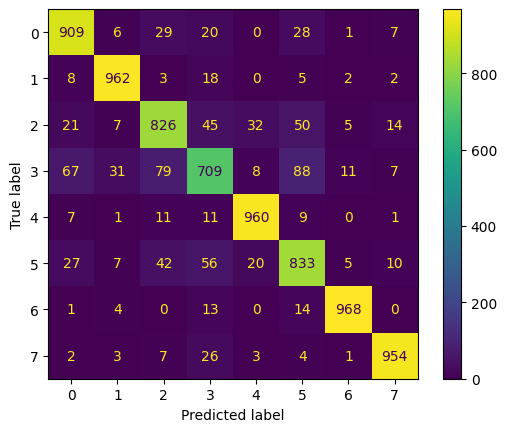

In [ ]:
# Confusion matrix
cm = confusion_matrix(test_labels, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

** Training and Validation Accuracy and Loss Visualization**

Ploted the model's training and validation accuracy and loss over the training epochs. These plots helped to assess the model's performance, monitor overfitting, and understand how well the model is learning and generalizing as it trains


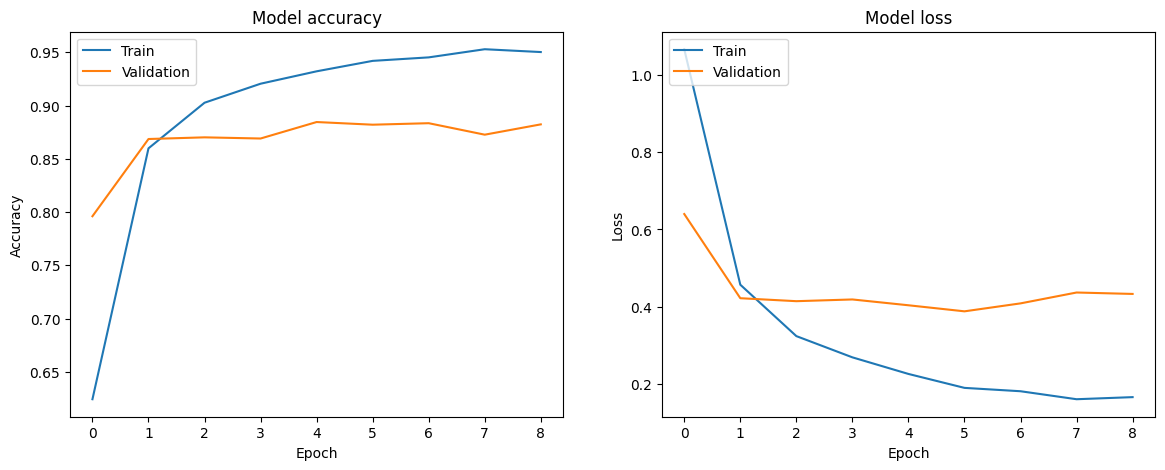

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()